# AutoML with Feature Engineering: A Lending Club Analysis

In this tutorial, we will go through a step-by-step workflow to build models using H2O's AutoML to determine loan deliquency. The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

We will highlight feature engineering methods to improve model performance.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Train default models using H2O's AutoML
4. Feature engineering to improve model performance
5. Train models using transformed data with AutoML
6. (Optional) Assignment: Transform test data
7. Stop H2O-3 cluster

# Step 1 (of 7). Start H2O Cluster

In [1]:
import h2o
h2o.init(max_mem_size = "6g")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.18.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /home/h2o/bin/miniconda3/envs/h2o/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5w4ysfaf
  JVM stdout: /tmp/tmp5w4ysfaf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5w4ysfaf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,24 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 22 days
H2O cluster name:,H2O_from_python_unknownUser_sclzg0
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


# Step 2 (of 7). Import Data

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|  Id   | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [2]:
# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv
loans = h2o.import_file("../../data/automl/loan.csv")
loans["bad_loan"] = loans["bad_loan"].asfactor()

loans.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456337,,13.715904065566173,5.684352932995329,,71915.670519749,,,15.881530121290105,0.2273570060625282,54.07917280242256,24.579733834274627,,14.854273655448347,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.55618873465,,4.3919398705457935,3.610663731100236,,59070.91565491825,,,7.587668224192548,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


# Step 3 (of 7). Train Default Models with AutoML

Start by splitting the data into train and test sets

In [3]:
train, test = loans.split_frame(seed=1234, ratios=[0.75])

and train 6 models excluding the `DeepLearning` algorithm

In [4]:
# Set target and predictor variables
y = "bad_loan"
x = train.col_names
x.remove(y)
x.remove("int_rate")

# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Print out a leaderboard with the 6 best models and two ensembles: a stacked ensemble of all models, and a best-of-family stacked ensemble:

In [5]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_151009,0.683789,0.445332,0.367648,0.374175,0.140007
StackedEnsemble_BestOfFamily_AutoML_20190810_151009,0.68368,0.445402,0.368503,0.374209,0.140032
GBM_1_AutoML_20190810_151009,0.680415,0.444744,0.368984,0.374063,0.139923
XGBoost_1_AutoML_20190810_151009,0.679169,0.445203,0.369436,0.374327,0.140121
XGBoost_3_AutoML_20190810_151009,0.677763,0.446219,0.371975,0.374468,0.140226
XGBoost_2_AutoML_20190810_151009,0.673588,0.447326,0.374567,0.375282,0.140837
GLM_grid_1_AutoML_20190810_151009_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
DRF_1_AutoML_20190810_151009,0.659914,0.454242,0.383668,0.377698,0.142656


As is frequently the case, the stacked ensemble models are among the best performers.

## Examine the Top Model

The `aml.leader` object contains the top model from the leaderboard

In [6]:
top_model = aml.leader

Details for both training and cross-validated data are contained in `aml.leader`

In [7]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190810_151009
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12169999939315387
RMSE: 0.3488552699804804
LogLoss: 0.3934205903521328
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117105.43670854633
Residual deviance: 96830.24937982832
AIC: 96844.24937982832
AUC: 0.8215398500095401
pr_auc: 0.533183547403585
Gini: 0.6430797000190802
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20646244376375703: 


,0,1,Error,Rate
0,81468.0,19083.0,0.1898,(19083.0/100551.0)
1,7976.0,14535.0,0.3543,(7976.0/22511.0)
Total,89444.0,33618.0,0.2199,(27059.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2064624,0.5179141,244.0
max f2,0.1563692,0.6458542,295.0
max f0point5,0.3025506,0.5218946,171.0
max accuracy,0.3827395,0.8397068,126.0
max precision,0.8745430,1.0,0.0
max recall,0.0827310,1.0,389.0
max specificity,0.8745430,1.0,0.0
max absolute_mcc,0.2269323,0.3971293,226.0
max min_per_class_accuracy,0.1827248,0.7361290,267.0
max mean_per_class_accuracy,0.1754125,0.7391401,274.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5851968,4.9826913,4.9826913,0.9114541,0.6564156,0.9114541,0.6564156,0.0498423,0.0498423,398.2691340,398.2691340
,2,0.0200062,0.5183467,4.0723066,4.5274989,0.7449228,0.5486259,0.8281885,0.6025208,0.0407356,0.0905779,307.2306558,352.7498949
,3,0.0300011,0.4735801,3.6933894,4.2496130,0.6756098,0.4941007,0.7773564,0.5664003,0.0369153,0.1274932,269.3389357,324.9613034
,4,0.0400042,0.4396159,3.4861076,4.0586979,0.6376929,0.4559944,0.7424335,0.5387932,0.0348718,0.1623651,248.6107577,305.8697897
,5,0.0500073,0.4126478,3.2063308,3.8881968,0.5865150,0.4259103,0.7112447,0.5162130,0.0320732,0.1944383,220.6330791,288.8196775
,6,0.1000065,0.3244455,2.7124958,3.3003940,0.4961807,0.3641261,0.6037215,0.4401757,0.1356226,0.3300609,171.2495774,230.0394040
,7,0.1500057,0.2736941,2.2638189,2.9548877,0.4141069,0.2971024,0.5405200,0.3924872,0.1131891,0.4432500,126.3818942,195.4887725
,8,0.2000049,0.2396983,1.8231383,2.6719619,0.3334959,0.2559099,0.4887661,0.3583443,0.0911554,0.5344054,82.3138332,167.1961872
,9,0.3000033,0.1966418,1.4415409,2.2618327,0.2636925,0.2162246,0.4137436,0.3109723,0.1441517,0.6785571,44.1540908,126.1832660
,10,0.4000016,0.1686482,1.1119189,1.9743601,0.2033967,0.1818592,0.3611579,0.2786947,0.1111901,0.7897472,11.1918919,97.4360065




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1400070508719978
RMSE: 0.37417516068279816
LogLoss: 0.4453322225152918
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117106.60132581185
Residual deviance: 109606.94793435368
AIC: 109620.94793435368
AUC: 0.683789150663501
pr_auc: 0.3231623112793986
Gini: 0.367578301327002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17896937221991976: 


,0,1,Error,Rate
0,68903.0,31648.0,0.3147,(31648.0/100551.0)
1,9467.0,13044.0,0.4205,(9467.0/22511.0)
Total,78370.0,44692.0,0.3341,(41115.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1789694,0.3881970,269.0
max f2,0.1167546,0.5536158,345.0
max f0point5,0.2555887,0.3518226,202.0
max accuracy,0.6404634,0.8174822,27.0
max precision,0.8412936,0.6666667,1.0
max recall,0.0724328,1.0,398.0
max specificity,0.8564152,0.9999901,0.0
max absolute_mcc,0.1996742,0.2139690,249.0
max min_per_class_accuracy,0.1670617,0.6310693,282.0
max mean_per_class_accuracy,0.1652131,0.6330774,284.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5613200,2.8155315,2.8155315,0.5150284,0.6272043,0.5150284,0.6272043,0.0281640,0.0281640,181.5531470,181.5531470
,2,0.0200062,0.4998846,2.5268729,2.6712022,0.4622258,0.5278722,0.4886271,0.5775383,0.0252765,0.0534405,152.6872881,167.1202175
,3,0.0300011,0.4588392,2.3022571,2.5482871,0.4211382,0.4781484,0.4661430,0.5444262,0.0230110,0.0764515,130.2257144,154.8287119
,4,0.0400042,0.4263619,2.2160098,2.4652009,0.4053615,0.4419809,0.4509445,0.5188097,0.0221669,0.0986185,121.6009785,146.5200912
,5,0.0500073,0.4016045,2.1982462,2.4118013,0.4021121,0.4134894,0.4411765,0.4977422,0.0219892,0.1206077,119.8246179,141.1801289
,6,0.1000065,0.3176781,1.8995467,2.1556948,0.3474728,0.3553514,0.3943284,0.4265526,0.0949758,0.2155835,89.9546664,115.5694788
,7,0.1500057,0.2698904,1.6969757,2.0027967,0.3104177,0.2921734,0.3663597,0.3817620,0.0848474,0.3004309,69.6975738,100.2796721
,8,0.2000049,0.2379077,1.4704161,1.8697070,0.2689745,0.2531446,0.3420144,0.3496089,0.0735196,0.3739505,47.0416150,86.9706986
,9,0.3000033,0.1967317,1.3300381,1.6898222,0.2432960,0.2157635,0.3091091,0.3049950,0.1330016,0.5069522,33.0038052,68.9822214
,10,0.4000016,0.1696951,1.0923726,1.5404628,0.1998212,0.1824403,0.2817877,0.2743569,0.1092355,0.6161876,9.2372602,54.0462845


To get details for the holdout test data, use `model_performance` as shown below

In [8]:
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13980429713871304
RMSE: 0.37390412827182457
LogLoss: 0.44475628676024154
Null degrees of freedom: 40924
Residual degrees of freedom: 40918
Null deviance: 39000.48288708934
Residual deviance: 36403.30207132577
AIC: 36417.30207132577
AUC: 0.6864964410321306
pr_auc: 0.32902482911565445
Gini: 0.3729928820642612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17090701322422405: 


,0,1,Error,Rate
0,21811.0,11609.0,0.3474,(11609.0/33420.0)
1,2889.0,4616.0,0.3849,(2889.0/7505.0)
Total,24700.0,16225.0,0.3543,(14498.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1709070,0.3890434,275.0
max f2,0.1155341,0.5571417,346.0
max f0point5,0.2661456,0.3547618,189.0
max accuracy,0.5124335,0.8177642,61.0
max precision,0.8786761,1.0,0.0
max recall,0.0716512,1.0,399.0
max specificity,0.8786761,1.0,0.0
max absolute_mcc,0.2045470,0.2180058,240.0
max min_per_class_accuracy,0.1670404,0.6322452,279.0
max mean_per_class_accuracy,0.1635175,0.6347981,283.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.5612798,2.9526170,2.9526170,0.5414634,0.6244019,0.5414634,0.6244019,0.0295803,0.0295803,195.2616955,195.2616955
,2,0.0200122,0.4996266,2.6931842,2.8230589,0.4938875,0.5270801,0.5177045,0.5758004,0.0269154,0.0564957,169.3184169,182.3058946
,3,0.0300061,0.4582440,2.3732019,2.6732287,0.4352078,0.4765957,0.4902280,0.5427591,0.0237175,0.0802132,137.3201891,167.3228705
,4,0.04,0.4270524,2.0265544,2.5116589,0.3716381,0.4426615,0.4605987,0.5177500,0.0202532,0.1004664,102.6554424,151.1658894
,5,0.0500183,0.3999206,2.2211128,2.4534645,0.4073171,0.4127000,0.4499267,0.4967092,0.0222518,0.1227182,122.1112754,145.3464504
,6,0.1000122,0.3170026,1.8949684,2.1742847,0.3475073,0.3540992,0.3987295,0.4254216,0.0947368,0.2174550,89.4968359,117.4284657
,7,0.1500061,0.2705654,1.6897468,2.0127983,0.3098729,0.2923025,0.3691155,0.3810558,0.0844770,0.3019320,68.9746751,101.2798331
,8,0.2,0.2389479,1.5298338,1.8920720,0.2805474,0.2537806,0.3469762,0.3492409,0.0764823,0.3784144,52.9833809,89.2071952
,9,0.3000122,0.1960347,1.2949784,1.6930245,0.2374786,0.2156189,0.3104740,0.3046966,0.1295137,0.5079280,29.4978362,69.3024545
,10,0.4,0.1696998,1.1100623,1.5473018,0.2035679,0.1821473,0.2837508,0.2740630,0.1109927,0.6189207,11.0062337,54.7301799


We can look at overall performance of the top model by 

In [9]:
print("AUC:     train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.auc(train = True), aml.leader.auc(xval = True), perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.logloss(train = True), aml.leader.logloss(xval = True), perf.logloss()))

AUC:     train = 0.8215, xval = 0.6838, test = 0.6865
Logloss: train = 0.3934, xval = 0.4453, test = 0.4448


Note that the cross-validation and test data metrics are very similar, but there is a gap between training and test metrics. Those for training are overly optimistic.

## Examine a Selected Model

In practice, the top performing model ranked by a leaderboard may not necessarily be the model you want to put into production. Other considerations, such as modeling type, regulatory or internal business preferences, likelihood of model approval, etc., may play a role in determining which model to use.  

Here we demonstrate how to select and evaluate any model from the leaderboard.

In [10]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_151009,0.683789,0.445332,0.367648,0.374175,0.140007
StackedEnsemble_BestOfFamily_AutoML_20190810_151009,0.68368,0.445402,0.368503,0.374209,0.140032
GBM_1_AutoML_20190810_151009,0.680415,0.444744,0.368984,0.374063,0.139923
XGBoost_1_AutoML_20190810_151009,0.679169,0.445203,0.369436,0.374327,0.140121
XGBoost_3_AutoML_20190810_151009,0.677763,0.446219,0.371975,0.374468,0.140226
XGBoost_2_AutoML_20190810_151009,0.673588,0.447326,0.374567,0.375282,0.140837
GLM_grid_1_AutoML_20190810_151009_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
DRF_1_AutoML_20190810_151009,0.659914,0.454242,0.383668,0.377698,0.142656


We can select an specified model from the leaderboard by indicating its position. The following code will select the best model that is not a stacked ensemble:

In [11]:
m = aml.leaderboard['model_id'].grep("StackedEnsemble", invert=True).min()
select_model = h2o.get_model(aml.leaderboard[int(m),'model_id'])

We can look at performance with the selected model just as we did with the top model

In [12]:
select_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190810_151009


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13303846380721596
RMSE: 0.3647443814607923
LogLoss: 0.4253219596579375
Mean Per-Class Error: 0.33560307595204186
AUC: 0.728655472170472
pr_auc: 0.4051867098660097
Gini: 0.457310944340944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2154313671945078: 


,0,1,Error,Rate
0,77261.0,23290.0,0.2316,(23290.0/100551.0)
1,10065.0,12446.0,0.4471,(10065.0/22511.0)
Total,87326.0,35736.0,0.271,(33355.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2154314,0.4273525,216.0
max f2,0.1294070,0.5720739,306.0
max f0point5,0.3045765,0.4222474,146.0
max accuracy,0.4007100,0.8247469,89.0
max precision,0.8365603,1.0,0.0
max recall,0.0429935,1.0,395.0
max specificity,0.8365603,1.0,0.0
max absolute_mcc,0.2463117,0.2773161,191.0
max min_per_class_accuracy,0.1826409,0.6635423,247.0
max mean_per_class_accuracy,0.1867782,0.6643969,243.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.30 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5016245,4.0767475,4.0767475,0.7457352,0.5594863,0.7457352,0.5594863,0.0407801,0.0407801,307.6747460,307.6747460
,2,0.0200062,0.4573835,3.1796854,3.6282164,0.5816409,0.4778902,0.6636881,0.5186883,0.0318067,0.0725867,217.9685382,262.8216421
,3,0.0300011,0.4271008,2.9511559,3.4026518,0.5398374,0.4417625,0.6224269,0.4930602,0.0294967,0.1020834,195.1155876,240.2651830
,4,0.0400042,0.4042979,2.7755634,3.2458479,0.5077173,0.4146905,0.5937437,0.4734638,0.0277642,0.1298476,177.5563358,224.5847867
,5,0.0500073,0.3857521,2.6823044,3.1331209,0.4906580,0.3947728,0.5731232,0.4577230,0.0268313,0.1566790,168.2304429,213.3120865
,6,0.1000065,0.3228448,2.2078454,2.6705207,0.4038680,0.3511169,0.4885025,0.4044243,0.1103905,0.2670694,120.7845397,167.0520722
,7,0.1500057,0.2822742,1.7973727,2.3794872,0.3287827,0.3014764,0.4352654,0.3701102,0.0898672,0.3569366,79.7372732,137.9487159
,8,0.2000049,0.2531603,1.5414937,2.1699973,0.2819763,0.2671319,0.3969447,0.3443667,0.0770734,0.4340100,54.1493668,116.9997298
,9,0.3000033,0.2115671,1.2936108,1.8778764,0.2366325,0.2312219,0.3435088,0.3066528,0.1293590,0.5633690,29.3610824,87.7876386
,10,0.4000016,0.1814306,1.0452837,1.6697325,0.1912075,0.1958391,0.3054342,0.2789499,0.1045267,0.6678957,4.5283746,66.9732454




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13992297031934203
RMSE: 0.37406278927386244
LogLoss: 0.44474413694944387
Mean Per-Class Error: 0.3688660247263468
AUC: 0.6804147026919566
pr_auc: 0.31858099156395653
Gini: 0.36082940538391317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18600733535173022: 


,0,1,Error,Rate
0,66468.0,34083.0,0.339,(34083.0/100551.0)
1,8982.0,13529.0,0.399,(8982.0/22511.0)
Total,75450.0,47612.0,0.3499,(43065.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1860073,0.3858648,242.0
max f2,0.1118602,0.5517922,325.0
max f0point5,0.2636427,0.3473701,172.0
max accuracy,0.5986268,0.8171897,18.0
max precision,0.8408710,1.0,0.0
max recall,0.0361245,1.0,397.0
max specificity,0.8408710,1.0,0.0
max absolute_mcc,0.2247045,0.2090421,206.0
max min_per_class_accuracy,0.1780727,0.6307139,250.0
max mean_per_class_accuracy,0.1791266,0.6311340,249.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.27 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.4986576,2.6290136,2.6290136,0.4809098,0.5549443,0.4809098,0.5549443,0.0262983,0.0262983,162.9013612,162.9013612
,2,0.0200062,0.4537815,2.5712819,2.6001478,0.4703493,0.4744062,0.4756296,0.5146752,0.0257208,0.0520190,157.1281894,160.0147753
,3,0.0300011,0.4249105,2.3955919,2.5319994,0.4382114,0.4389173,0.4631636,0.4894362,0.0239438,0.0759629,139.5591893,153.1999403
,4,0.0400042,0.4023723,2.1849235,2.4452128,0.3996751,0.4129489,0.4472882,0.4703105,0.0218560,0.0978188,118.4923475,144.5212796
,5,0.0500073,0.3839489,2.1183100,2.3798216,0.3874898,0.3927437,0.4353266,0.4547946,0.0211896,0.1190085,111.8309955,137.9821604
,6,0.1000065,0.3210816,1.8951043,2.1374827,0.3466602,0.3491438,0.3909970,0.4019735,0.0947537,0.2137622,89.5104319,113.7482654
,7,0.1500057,0.2814449,1.6196789,1.9648908,0.2962782,0.2998949,0.3594258,0.3679491,0.0809826,0.2947448,61.9678937,96.4890765
,8,0.2000049,0.2527056,1.5512668,1.8614890,0.2837640,0.2664622,0.3405111,0.3425784,0.0775621,0.3723069,55.1266826,86.1488982
,9,0.3000033,0.2115548,1.2940551,1.6723495,0.2367138,0.2308502,0.3059129,0.3053367,0.1294034,0.5017103,29.4055059,67.2349464
,10,0.4000016,0.1818525,1.1181382,1.5337995,0.2045344,0.1962851,0.2805688,0.2780743,0.1118120,0.6135223,11.8138202,53.3799463



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6609105,0.0165720,0.6539227,0.7040995,0.6330652,0.6534211,0.6600439
auc,0.6805715,0.0023720,0.6776294,0.685484,0.6772013,0.6789119,0.683631
err,0.3390895,0.0165720,0.3460773,0.2959005,0.3669348,0.3465789,0.3399561
err_count,8345.8,407.80814,8518.0,7283.0,9031.0,8530.0,8367.0
f0point5,0.3222187,0.0051022,0.3249320,0.3331866,0.3108192,0.3213227,0.3208329
f1,0.3869287,0.0023923,0.3920057,0.3839973,0.3824957,0.3886181,0.3875265
f2,0.4849998,0.0114318,0.4939737,0.4530938,0.4971384,0.4915684,0.4892248
lift_top_group,2.634336,0.1386979,2.8191972,2.870326,2.3682537,2.45763,2.6562731
logloss,0.4447441,0.0031894,0.4503359,0.4375596,0.4461804,0.4477173,0.4419276
max_per_class_error,0.4152575,0.0256954,0.4023939,0.4851440,0.3787206,0.4029949,0.4070340


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-08-10 15:15:01,9.965 sec,0.0,0.3866042,0.4757985,0.5,0.0,1.0,0.8170759
,2019-08-10 15:15:01,10.204 sec,5.0,0.3792772,0.4580105,0.6911714,0.3462696,3.2818261,0.3319709
,2019-08-10 15:15:01,10.333 sec,10.0,0.3747794,0.4477681,0.6972953,0.3557062,3.4994303,0.3255432
,2019-08-10 15:15:02,10.478 sec,15.0,0.3721893,0.4419315,0.7034835,0.3650609,3.5926892,0.3157270
,2019-08-10 15:15:02,10.611 sec,20.0,0.3703693,0.4378827,0.7073326,0.3725101,3.7303572,0.3199850
,2019-08-10 15:15:02,10.742 sec,25.0,0.3690813,0.4349085,0.7118131,0.3788893,3.8191752,0.3079098
,2019-08-10 15:15:02,10.873 sec,30.0,0.3679729,0.4324785,0.7155112,0.3850300,3.8813478,0.2969316
,2019-08-10 15:15:02,11.000 sec,35.0,0.3669982,0.4302876,0.7199418,0.3912054,3.9524022,0.2783475
,2019-08-10 15:15:02,11.131 sec,40.0,0.3660486,0.4281977,0.7236939,0.3971178,3.9568431,0.2940469
,2019-08-10 15:15:02,11.262 sec,45.0,0.3653671,0.4267013,0.7264248,0.4014291,4.0234566,0.2720336


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
addr_state,1913.5792236,1.0,0.2018574
term,1793.5231934,0.9372610,0.1891930
annual_inc,1277.7316895,0.6677182,0.1347838
revol_util,1040.8331299,0.5439195,0.1097942
dti,842.0133667,0.4400201,0.0888213
purpose,821.2640381,0.4291769,0.0866325
loan_amnt,630.3903809,0.3294300,0.0664979
emp_length,271.9709473,0.1421268,0.0286893
longest_credit_length,260.9221497,0.1363529,0.0275238
home_ownership,221.3427429,0.1156695,0.0233487


and performance on test data

In [13]:
select_perf = select_model.model_performance(test_data=test)
select_perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13978573360354507
RMSE: 0.37387930352393817
LogLoss: 0.44422760717751736
Mean Per-Class Error: 0.36509998720182946
AUC: 0.6836944211539006
pr_auc: 0.3240234242480871
Gini: 0.3673888423078011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.180966674809329: 


,0,1,Error,Rate
0,21552.0,11868.0,0.3551,(11868.0/33420.0)
1,2815.0,4690.0,0.3751,(2815.0/7505.0)
Total,24367.0,16558.0,0.3588,(14683.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1809667,0.3898101,246.0
max f2,0.1192676,0.5566110,315.0
max f0point5,0.2742449,0.3513180,161.0
max accuracy,0.4810957,0.8173488,46.0
max precision,0.8211453,1.0,0.0
max recall,0.0329456,1.0,399.0
max specificity,0.8211453,1.0,0.0
max absolute_mcc,0.2081758,0.2140630,217.0
max min_per_class_accuracy,0.1786103,0.6321119,248.0
max mean_per_class_accuracy,0.1809667,0.6349000,246.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.27 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.4984838,2.7664159,2.7664159,0.5073171,0.5486187,0.5073171,0.5486187,0.0277149,0.0277149,176.6415885,176.6415885
,2,0.0200122,0.4526887,2.6398538,2.7032121,0.4841076,0.4727909,0.4957265,0.5107511,0.0263824,0.0540973,163.9853789,170.3212104
,3,0.0300061,0.4214331,2.5065278,2.6377041,0.4596577,0.4363325,0.4837134,0.4859651,0.0250500,0.0791472,150.6527840,163.7704071
,4,0.04,0.3995750,2.1198826,2.5083278,0.3887531,0.4099762,0.4599878,0.4669795,0.0211859,0.1003331,111.9882588,150.8327781
,5,0.0500183,0.3812577,2.1147121,2.4294893,0.3878049,0.3901904,0.4455300,0.4515992,0.0211859,0.1215190,111.4712143,142.9489280
,6,0.1000122,0.3206931,1.8256728,2.1276548,0.3347996,0.3483346,0.3901784,0.3999795,0.0912725,0.2127915,82.5672751,112.7654778
,7,0.1500061,0.2810874,1.7163989,1.9905918,0.3147605,0.2999402,0.3650432,0.3666385,0.0858095,0.2986009,71.6398908,99.0591818
,8,0.2,0.2522394,1.5005164,1.8680879,0.2751711,0.2662293,0.3425779,0.3415393,0.0750167,0.3736176,50.0516436,86.8087941
,9,0.3000122,0.2115274,1.3216240,1.6859185,0.2423650,0.2307032,0.3091709,0.3045909,0.1321785,0.5057961,32.1624007,68.5918461
,10,0.4,0.1816003,1.1407123,1.5496336,0.2091887,0.1959844,0.2841784,0.2774426,0.1140573,0.6198534,14.0712318,54.9633578


A summary is then given by

In [14]:
print("AUC:     train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.auc(train = True), select_model.auc(xval = True), select_perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.logloss(train = True), select_model.logloss(xval = True), select_perf.logloss()))

AUC:     train = 0.7287, xval = 0.6804, test = 0.6837
Logloss: train = 0.4253, xval = 0.4447, test = 0.4442


We next look at variable importance plots for our selected model.

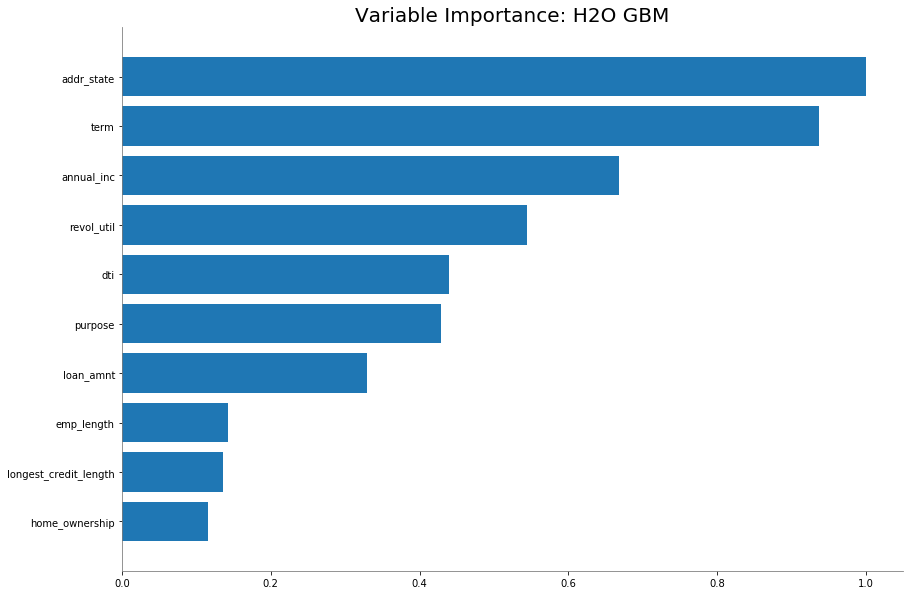

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

select_model.varimp_plot()

Note that `addr_state`, a high-cardinality categorical variable, is the most important variable. We will next try some feature engineering to see whether we can improve this model's overall performance.

# Step 4 (of 7). Feature Engineering to Improve Model Performance

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform four feature engineering tasks on select variables:

**Creating Target Encoding** 
   - Loan Purpose
   - State of Residence

**Separating Typical from Extreme**
   - Loan Amount
   - Annual Income
   - Debt to Income Ratio
   - Number of Delinquencies in the Past 2 Years
   - Revolving Credit Line Utilized
   - Number of Credit Lines
   - Longest Credit Length

**Creating Indicator Functions**
   - Term
   - Income Verification Status
   - Employment Length (Missing Value)

**Combining Categories** 
   - Home Ownership

## 1. Creating Target Encoding

### Cross Validation with Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one-hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [16]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

In [17]:
cv_nfolds = 5
cv_seed = 1234
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

train["cv_fold"].table()

cv_fold,Count
0,24674
1,24621
2,24740
3,24478
4,24549


In [18]:
import numpy as np
import pandas as pd

In [19]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [20]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [21]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### 1.1. Creating Target Encoding for Loan Purpose

In [22]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  69976    56.86
1          credit_card  23082    18.76
2                other   7916     6.43
3     home_improvement   7346     5.97
4       major_purchase   3535     2.87
5       small_business   2912     2.37
6                  car   2126     1.73
7              medical   1540     1.25
8              wedding   1320     1.07
9               moving   1091     0.89
10               house    937     0.76
11            vacation    834     0.68
12         educational    303     0.25
13    renewable_energy    144     0.12


Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting the later group.

In [23]:
df = mean_target(train, "purpose")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,purpose,nrow,mean_bad_loan
0,small_business,2912,0.305975
1,other,7916,0.218671
2,educational,303,0.211221
3,moving,1091,0.206233
4,renewable_energy,144,0.201389
5,medical,1540,0.194156
6,debt_consolidation,69976,0.189465
7,house,937,0.177161
8,vacation,834,0.171463
9,credit_card,23082,0.155966


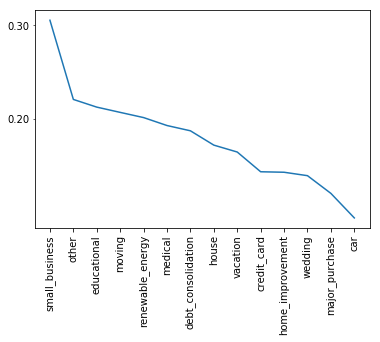

In [24]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [25]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [26]:
train = train.merge(te_purpose, all_x = True)

Replace `purpose` with target encoded `te_purpose`

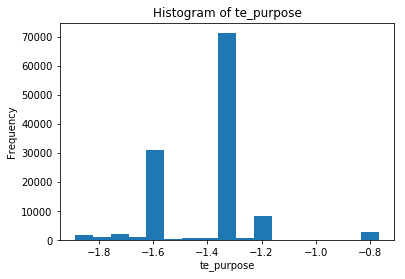

In [27]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

train["te_purpose"].hist()

### 1.2. Target Encoding for State of Residence

We will also use a mean target encoding for *state of residence* for a reason similar to that for *purpose*.

In [28]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:10])

  addr_state  Count  Percent
0         CA  21493    17.47
1         NY  10699     8.69
2         TX   9188     7.47
3         FL   8554     6.95
4         NJ   4755     3.86
5         IL   4564     3.71
6         PA   4090     3.32
7         VA   3957     3.22
8         GA   3937     3.20
9         OH   3666     2.98


In [29]:
df = mean_target(train, "addr_state")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,addr_state,nrow,mean_bad_loan
0,NE,8,0.625000
1,IA,7,0.285714
2,MS,124,0.233871
3,NV,1764,0.231859
4,TN,977,0.220061
5,IN,1086,0.214549
6,OK,993,0.214502
7,AL,1474,0.213026
8,FL,8554,0.210077
9,NJ,4755,0.204627


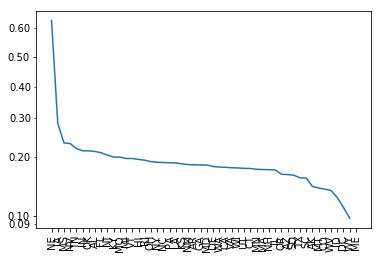

In [30]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [31]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


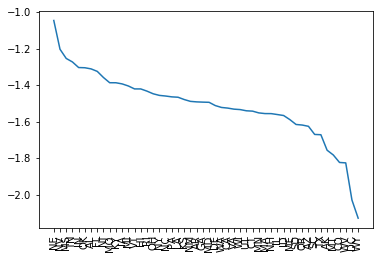

In [32]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

plt.xticks(rotation = 90)
plt.plot(df["addr_state"], df["mean_te_addr_state"])

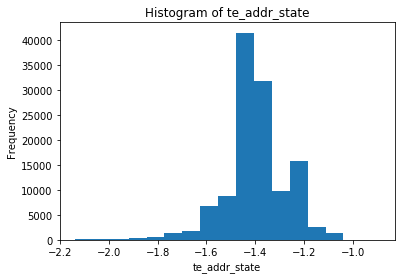

In [33]:
train = train.merge(te_addr_state, all_x = True)

x_trans.remove("addr_state")
x_trans.append("te_addr_state")

train["te_addr_state"].hist()

## 2. Separating Typical from Extreme

### 2.1. Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \\$5,000 and above \\$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
\text{loan_amnt_core} & = & \max(5000, \min(\text{loan_amnt}, 30000)) \\
\text{loan_amnt_diff} & = & \text{loan_amnt} - \text{loan_amnt_core}
\end{eqnarray}

In [34]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11400
0.75,18000
0.95,30000
1,35000


In [35]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

df = mean_target(train, "loan_amnt_cat")
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",19317,0.163845
1,"(5000.0,10000.0]",37730,0.164431
2,"(10000.0,15000.0]",26782,0.173288
3,"(15000.0,20000.0]",18485,0.209413
4,"(20000.0,25000.0]",10829,0.211931
5,"(25000.0,30000.0]",5223,0.241432
6,"(30000.0,35000.0]",4696,0.228705


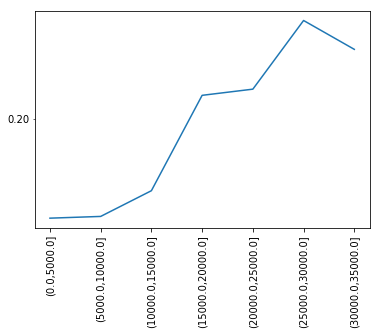

In [36]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [37]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### 2.2. Separating Typical from Extreme Annual Income

Looking at the occurrence of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \\$10,000 to \\$105,000 and is relatively flat above \\$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
\text{annual_inc_core} & = & \max(10000, \min(\text{annual_inc}, 105000)) \\
\text{annual_inc_diff} & = & \text{annual_inc} - \text{annual_inc_core}
\end{eqnarray}

In [38]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,3000
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,146000
1,6.1e+06


In [39]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN
df

,annual_inc_cat,nrow,mean_bad_loan
1,"(0.0,5000.0]",17,0.294118
2,"(5000.0,10000.0]",145,0.213793
3,"(10000.0,15000.0]",668,0.282934
4,"(15000.0,20000.0]",1364,0.249267
5,"(20000.0,25000.0]",2929,0.235575
6,"(25000.0,30000.0]",4942,0.238770
7,"(30000.0,35000.0]",6058,0.230934
8,"(35000.0,40000.0]",8778,0.232969
9,"(40000.0,45000.0]",8876,0.212483
10,"(45000.0,50000.0]",9555,0.206593


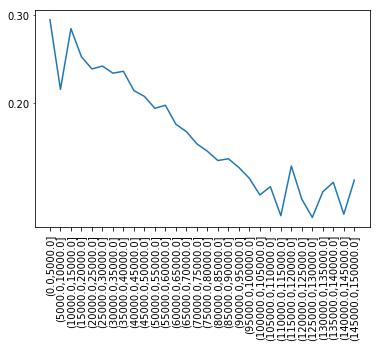

In [40]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["annual_inc_cat"], df["mean_bad_loan"])

In [41]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### 2.3. Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
\text{dti_core} & = & \max(5, \min(\text{dti}, 30)) \\
\text{dti_diff} & = & \text{dti} - \text{dti_core}
\end{eqnarray}

In [42]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.76
0.25,10.2
0.5,15.6
0.75,21.25
0.95,29.01
1,39.93


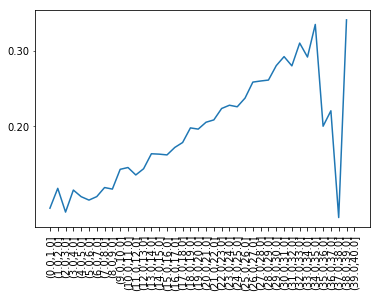

In [43]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["dti_cat"], df["mean_bad_loan"])

In [44]:
df

,dti_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",1136,0.122359
2,"(1.0,2.0]",1438,0.138387
3,"(2.0,3.0]",1767,0.119411
4,"(3.0,4.0]",2191,0.136924
5,"(4.0,5.0]",2693,0.131452
6,"(5.0,6.0]",3186,0.128688
7,"(6.0,7.0]",3612,0.131506
8,"(7.0,8.0]",4142,0.139063
9,"(8.0,9.0]",4603,0.137736
10,"(9.0,10.0]",4841,0.155340


In [45]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### 2.4. Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
\text{delinq_2yrs_core} & = & \min(\text{delinq_2yrs}, 3) \\
\text{delinq_2yrs_diff} & = & \text{delinq_2yrs} - \text{delinq_2yrs_core}
\end{eqnarray}

In [46]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,18


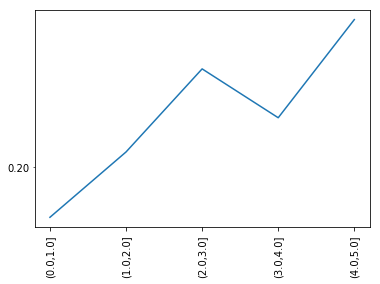

In [47]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

df = mean_target(train, "delinq_2yrs_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["delinq_2yrs_cat"], df["mean_bad_loan"])

In [48]:
df

,delinq_2yrs_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",12879,0.189766
2,"(1.0,2.0]",3467,0.203057
3,"(2.0,3.0]",1127,0.220941
4,"(3.0,4.0]",447,0.210291
5,"(4.0,5.0]",237,0.232068


In [49]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)
train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### 2.5. Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
\text{revol_util_0} & = & I(\text{revol_util} == 0) \\
\text{revol_util_core} & = & \max(5, \min(\text{revol_util}, 30)) \\
\text{revol_util_diff} & = & \text{revol_util} - \text{revol_util_core}
\end{eqnarray}

In [50]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.6
0.25,35.5
0.5,55.9
0.75,74.3
0.95,92.4
1,150.7


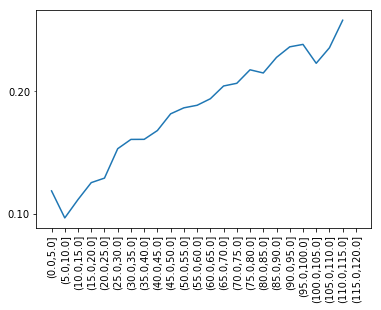

In [51]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["revol_util_cat"], df["mean_bad_loan"])

In [52]:
df

,revol_util_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",2833,0.114366
2,"(5.0,10.0]",3089,0.097443
3,"(10.0,15.0]",3294,0.108682
4,"(15.0,20.0]",3874,0.120031
5,"(20.0,25.0]",4577,0.123225
6,"(25.0,30.0]",5272,0.145865
7,"(30.0,35.0]",6005,0.153705
8,"(35.0,40.0]",6679,0.153766
9,"(40.0,45.0]",7182,0.161515
10,"(45.0,50.0]",7895,0.177074


In [53]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)
train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### 2.6. Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
\text{total_acc_core} & = & \min(\text{total_acc}, 50) \\
\text{total_acc_diff} & = & \text{total_acc} - \text{total_acc_core}
\end{eqnarray}

In [54]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,102


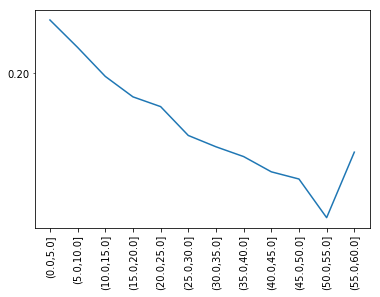

In [55]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["total_acc_cat"], df["mean_bad_loan"])

In [56]:
df

,total_acc_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",1753,0.225328
2,"(5.0,10.0]",9578,0.212048
3,"(10.0,15.0]",17664,0.198653
4,"(15.0,20.0]",21658,0.189584
5,"(20.0,25.0]",21346,0.185374
6,"(25.0,30.0]",17509,0.173339
7,"(30.0,35.0]",12921,0.168795
8,"(35.0,40.0]",8476,0.164936
9,"(40.0,45.0]",5312,0.159074
10,"(45.0,50.0]",3153,0.156359


In [57]:
(train["total_acc"] == None).table()

C1,Count
0,123039
1,23


In [58]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### 2.7. Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
\text{longest_credit_length_core} & = & \max(3, \min(\text{longest_credit_length}, 20)) \\
\text{longest_credit_length_diff} & = & \text{longest_credit_length} - \text{longest_credit_length_core}
\end{eqnarray}

In [59]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


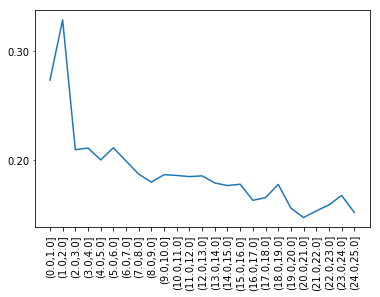

In [60]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["longest_credit_length_cat"], df["mean_bad_loan"])

In [61]:
df

,longest_credit_length_cat,nrow,mean_bad_loan
1,"(0.0,1.0]",48,0.270833
2,"(1.0,2.0]",72,0.333333
3,"(2.0,3.0]",700,0.208571
4,"(3.0,4.0]",1881,0.209995
5,"(4.0,5.0]",2999,0.200400
6,"(5.0,6.0]",4016,0.210159
7,"(6.0,7.0]",4760,0.199580
8,"(7.0,8.0]",5302,0.189363
9,"(8.0,9.0]",5729,0.183453
10,"(9.0,10.0]",7349,0.189005


In [62]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)
train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

## 3. Create Indicator Functions

### 3.1. Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [63]:
train["term"].table()

term,Count
36 months,97490
60 months,25572


In [64]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

train["term_60months"].table()

term_60months,Count
0,97490
1,25572


### 3.2. Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [65]:
train["verification_status"].table()

verification_status,Count
not verified,44247
verified,78815


In [66]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"
train["verified"].table()

verified,Count
0,44247
1,78815


### 3.3. Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [67]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6807001583611285
maxs,10.0
sigma,3.610320673601876
zeros,10727
missing,4346
0,nan
1,7.0
2,2.0


In [68]:
x_trans.append("emp_length_missing")
train["emp_length_missing"] = train["emp_length"] == None

mean_target_encoding(train, "emp_length_missing")

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52085
1,0,-1.0216
0,1,-1.51402
1,1,-1.06329
0,2,-1.51493
1,2,-1.03287
0,3,-1.51542
1,3,-0.986137
0,4,-1.51821
1,4,-1.01942


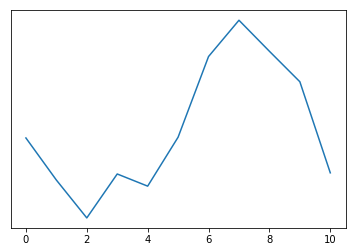

In [69]:
df = mean_target(train, "emp_length")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [70]:
df

,emp_length,nrow,mean_bad_loan
1,0.0,10727,0.180852
2,1.0,8506,0.176699
3,2.0,11877,0.173023
4,3.0,10243,0.177292
5,4.0,8285,0.176101
6,5.0,9313,0.180930
7,6.0,7472,0.189106
8,7.0,6766,0.192876
9,8.0,5584,0.189649
10,9.0,4600,0.186522


## 4. Combining Categories
### 4.1.  Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [71]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,NONE,27,0.259259
2,OTHER,116,0.215517
3,OWN,10165,0.189670
4,RENT,52853,0.204284


In [72]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()
train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
MORTGAGE,MORTGAGE,59901
NONE,OTHER,27
OTHER,OTHER,116
OWN,OWN,10165
RENT,OTHER,52853


In [73]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,OTHER,52996,0.204336
2,OWN,10165,0.189670


In [74]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

# Step 5 (of 7). Train Models using Transformed Data

The complete variable set, including transformed variables, are

In [75]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

We now fit a new set of models using AutoML

In [76]:
aml_trans = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml_trans.train(x = x_trans, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [77]:
print(aml_trans.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_151532,0.682815,0.445326,0.366448,0.374124,0.139969
StackedEnsemble_BestOfFamily_AutoML_20190810_151532,0.682305,0.445509,0.367609,0.374204,0.140029
GBM_1_AutoML_20190810_151532,0.681793,0.444364,0.368744,0.373891,0.139794
XGBoost_3_AutoML_20190810_151532,0.679529,0.445667,0.370276,0.374154,0.139992
XGBoost_1_AutoML_20190810_151532,0.6787,0.445197,0.369267,0.374287,0.140091
GLM_grid_1_AutoML_20190810_151532_model_1,0.676896,0.445621,0.37133,0.374356,0.140142
XGBoost_2_AutoML_20190810_151532,0.672059,0.447783,0.374339,0.375402,0.140926
DRF_1_AutoML_20190810_151532,0.661691,0.452594,0.382219,0.377428,0.142452


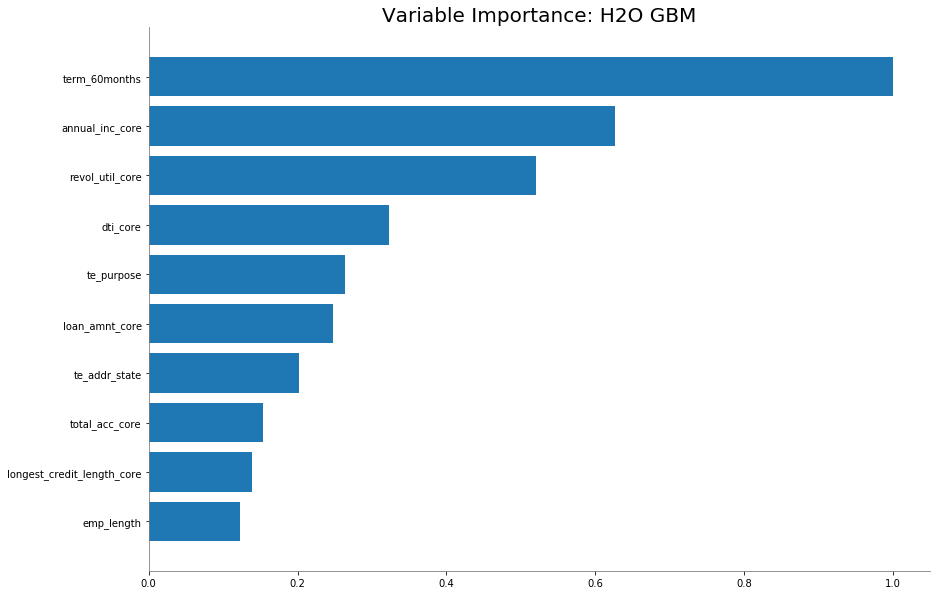

In [78]:
best_model_trans = h2o.get_model(aml_trans.leaderboard[2,'model_id'])
best_model_trans.varimp_plot()

In [79]:
print("AUC     (transformed): train = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.auc(train = True),
              best_model_trans.auc(xval = True)))
print("Logloss (transformed): train = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.logloss(train = True),
              best_model_trans.logloss(xval = True)))

AUC     (transformed): train = 0.7142, xval = 0.6818
Logloss (transformed): train = 0.4309, xval = 0.4444


Note that the cross-validated model performance is now much closer to that of the training model. 


# Step 6 (of 7). Assignment: Transform Test Data (Optional)

In order to use the `model_performance` command to evaluate the model on the holdout training data set, you will need to transform the training data using the same feature engineering transformations created above. In other words, transform the data from


In [80]:
y = "bad_loan"
x_test = test.col_names
x_test.remove(y)
x_test.remove("int_rate")
x_test

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

to the variables below

In [81]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

# Step 7 (of 7). Shutdown H2O Cluster

In [82]:
h2o.cluster().shutdown()

H2O session _sid_9fb5 closed.
